#**Init**

In [1]:
# get plot summary from OMDb api
# tf-idf glove plot vector
# get trailer from youtube using pytube
# rnn-lstm architecture

In [2]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pytube # pytube for downloading the trailers from youtube
!pip install omdbapi # omdbapi for getting movie details from pmdb dataset
!pip install -U sentence-transformers # sentence transformer SBERT

     |████████████████████████████████| 56 kB 2.3 MB/s 
  Created wheel for omdbapi: filename=omdbapi-0.6.0-py3-none-any.whl size=17780 sha256=cd78b3eaa45d2e5fdfc6a3bf82a330a567bc3d91a8d350474ab123fb9718a2de
  Stored in directory: /root/.cache/pip/wheels/70/10/6e/62bd836b5d2ade8bba189f402b8e0251ccee43df75ecd9d2d6
Successfully built omdbapi
     |████████████████████████████████| 79 kB 3.3 MB/s 
     |████████████████████████████████| 4.0 MB 32.3 MB/s 
     |████████████████████████████████| 1.2 MB 41.2 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 37.8 MB/s 
     |████████████████████████████████| 895 kB 38.9 MB/s 
     |████████████████████████████████| 6.6 MB 35.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=d59cb502036ff2b5e75faef7411afd23bd6b169315a2a3243e52b9d43059754c
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa

In [143]:
# required imports
import numpy as np
import pandas as pd
import os, cv2, math, torch, torchvision, pathlib
import regex as re
from omdbapi.movie_search import GetMovie
from pytube import YouTube
from sklearn.manifold import TSNE
import seaborn as sns
import plotly.graph_objects as go
import urllib.request
from PIL import Image
from torchvision import transforms
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from pylab import rcParams
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import average_precision_score, mean_squared_error, precision_score, recall_score 
from sentence_transformers import SentenceTransformer, util
from numpy import linalg as LA
import keras
import keras.layers as layers
from sklearn.neighbors import KNeighborsClassifier

In [5]:
device='cpu'
if torch.cuda.is_available(): # checking if gpu(cuda) is available
  device='cuda'
device

'cpu'

In [6]:
!unzip /content/drive/MyDrive/ml-100k.zip # extracting the MovieLens 100k dataset

Archive:  /content/drive/MyDrive/ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [7]:
data = pd.read_csv('/content/ml-100k/u.data', header=None, delimiter='\t')
data.columns=['userid','itemid','rating','timestamp']
users = pd.read_csv('/content/ml-100k/u.user', header=None, delimiter='\|')
users.columns=['userid','age','gender','accupation','zipcode']
items = pd.read_csv('/content/ml-100k/u.item', header=None, delimiter='\|',encoding="windows-1252")
items.columns=['movieid', 'movietitle', 'releasedate', 'videoreleasedate', 'imdburl', 'unknown', 'Action', 'Adventure',\
               'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror',\
               'Musical', 'Mystery', 'Romance', 'Sci-Fi','Thriller', 'War', 'Western']

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


#**Pre-processing**

**Filter Data**

In [8]:
# methods for convering vectors saved in pandas dataframe back to np array
def convertergenre(instr):
    return np.fromstring(instr[1:-1],sep=' ').astype(int)
def converter(instr):
    return np.fromstring(instr[1:-1],sep=' ')

In [9]:
it=data.groupby('itemid')
it=pd.DataFrame(it.size())
it=it.where(it[0]>=70) # selecting movies which are being rated by atleast 70 users
it=it.dropna()
# it
us=data.groupby('userid')
us=pd.DataFrame(us.size())
us=us.where(us[0]>=70) # selecting users who rated atleast 70 movies
us=us.dropna()
# us
###############################
dropindex=[]
for i,row in data.iterrows(): # dropping user-movie interaction which does not satisfy above condition
    if (row['userid'] in us[0]) and (row['itemid'] in it[0]):
        pass
    else:
        dropindex.append(i)
data.drop(dropindex, inplace = True)
data=data.reset_index()
###############################
dropusersindex=[]
for i,row in users.iterrows():
    if row['userid'] not in us[0]: # dropping users from users list
        dropusersindex.append(i)
users.drop(dropusersindex,inplace=True)
users=users.reset_index()
##############################
dropitemsindex=[]
for i,row in items.iterrows():
    if row['movieid'] not in it[0]: # dropping movies from movies list
        dropitemsindex.append(i)
items.drop(dropitemsindex,inplace=True)
items=items.reset_index()

In [10]:
# clearing clutter in movie_title of all the movies 
movietitleReg='\([a-zA-Z0-9\s]*[\)]*'
items['movietitle']=items['movietitle'].apply(lambda x:",".join(re.sub(movietitleReg,'',x).strip().split(',')[:-1] if len(re.sub(movietitleReg,'',x).strip().split(','))>=2 else re.sub(movietitleReg,'',x).strip().split(',')))

itemswithoutonehot=items

In [11]:
# reading already calculated movie vectors
items1=pd.read_csv('/content/drive/MyDrive/itemsAfterAllProc-actorsAndAllEmbb.csv', delimiter=',',converters={'trailervec':converter,'senPlotEmbb':converter,'actorsEmbb':converter,'directorEmbb':converter,'genre':convertergenre})

In [12]:
# removing duplicate entries in the movie list
items1.drop_duplicates(subset ="movietitle",
                     keep = "first", inplace = True)
items1=items1.reset_index()
items1.drop('level_0', axis=1, inplace=True)
items1.drop('Unnamed: 0', axis=1, inplace=True)
items=items1

# **Genre lables**

In [13]:
itemswithoutonehotcols=itemswithoutonehot.columns[6:]
genre=items['genre'].apply(lambda x:re.sub('[,]+'," ",",".join(itemswithoutonehotcols*x)).strip())
items['genredesc']=genre.tolist()
itemswithoutonehotcols

Index(['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

# **Movie details from OMDB**

**Plot vector build**

In [ ]:
movie = GetMovie(api_key='f5391a82') # omdb dataset api setup for data fetch

In [ ]:
moviedata=items['movietitle'].apply(lambda x:movie.get_movie(title=str(x)))
plots=moviedata.apply(lambda x: x['plot'] if type(x)==dict else x)
actors=moviedata.apply(lambda x: x['actors'] if type(x)==dict else x)
director=moviedata.apply(lambda x: x['director'] if type(x)==dict else x)
imdbrating=moviedata.apply(lambda x: x['imdbrating'] if type(x)==dict else x)
items['plot']=plots # movie plot
items['actors']=actors # movie actors
items['director']=director # movie directors
items['imdbrating']=imdbrating # movie imdb rating
items['plot']=items['plot'].apply(lambda x: 'Movie not found!' if x.lower()=='n/a' else x)
items['actors']=items['actors'].apply(lambda x: 'Actors not found!' if x.lower()=='n/a' else x)
items['director']=items['director'].apply(lambda x: 'Director not found!' if x.lower()=='n/a' else x)
items['imdbrating']=items['imdbrating'].apply(lambda x: 'Ratings not found!' if x.lower()=='n/a' else x)

#**Sentence Bert Embeddings**

Language model sentence embeeding for plot

In [14]:
senmodel = SentenceTransformer('all-MiniLM-L6-v2') #multi-qa-MiniLM-L6-cos-v1

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [15]:
def getSentenceEmbb(plot):
  return senmodel.encode(plot)

In [16]:
# combining movie plot, movie actors and movie director in a single text
movieTextInfo = items[['genredesc','plot']].agg('. Plot: '.join, axis=1)
items['movieTextInfo']=movieTextInfo
movieTextInfo = items[['movieTextInfo','actors']].agg(' Played by: '.join, axis=1)
items['movieTextInfo']=movieTextInfo
movieTextInfo = items[['movieTextInfo','director']].agg('. Directed by: '.join, axis=1)
items['movieTextInfo']=movieTextInfo

In [17]:
movieTextInfoEmbb = items['movieTextInfo'].apply(lambda x:getSentenceEmbb(x))
items['movieTextInfoEmbb']=movieTextInfoEmbb
# senPlotEmbb = items['plot'].apply(lambda x:getSentenceEmbb(x))
# actorsEmbb = items['actors'].apply(lambda x:getSentenceEmbb(x))
# directorEmbb = items['director'].apply(lambda x:getSentenceEmbb(x))
# items['senPlotEmbb']=senPlotEmbb
# items['actorsEmbb']=actorsEmbb
# items['directorEmbb']=directorEmbb

#**Visual Embeddings**

In [ ]:
device

**Trailer Vector Build**

In [ ]:
def downloadTrailer(title,path):
    t=title
    title=title.split(" ")
    title="+".join(title)+"+trailer"
    if not os.path.exists(path+t+'.mp4'):
        print(title)
        html = urllib.request.urlopen("https://www.youtube.com/results?search_query="+title)
        video_ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
        trailerlink="https://www.youtube.com/watch?v="+video_ids[0]
        yt = YouTube(trailerlink)
        regex = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
        t=re.sub('[\*\$\%\@\&\/]+', '', t)
        yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().download(path,t+'.mp4',None)

In [ ]:
for i,row in items.iterrows():
  downloadTrailer(row['movietitle'],'/content/trailers/')

In [ ]:
def convertTrailer2Frames(title,trailerpath,framespath):
    if not os.path.exists(framespath +title.rstrip('.')):
        print(title)
        cam = cv2.VideoCapture(trailerpath + title +".mp4")
        try:
            if not os.path.exists(framespath+title.strip().rstrip('.')):
                os.makedirs(framespath+title.strip().rstrip('.'))
        except OSError:
            print ('Error: Creating directory of data')
        currentframe = -10
        f=math.ceil(cam.get(cv2.CAP_PROP_FRAME_COUNT)/130)
        i=0
        while(True):
            ret,frame = cam.read()
            if ret:
                name = framespath +title.strip().rstrip('.') +'/frame' + str(currentframe) + '.jpg'
                if i % f == 0:
                    cv2.imwrite(name, frame)
                    i=0
                    if currentframe<0 or currentframe>=110:
                        file_to_rem = pathlib.Path(framespath+title.strip().rstrip('.') +'/frame' + str(currentframe) + '.jpg')
                        file_to_rem.unlink()
                    currentframe += 1
                i=i+1
            else:
                break
        cam.release()
        cv2.destroyAllWindows()

In [ ]:
for i,row in items.iterrows():
    convertTrailer2Frames(re.sub('[\*\$\%\@\&\/\:]+', '', str(row['movietitle'])),'/content/trailers/','/content/trailersFrames/')

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True) # loading Resnet50 pretrained model to get the trailer frames embeddings

In [ ]:
# getting 
def getTrailerEmbb(f,l,x,device):
  input_per=[]
  probs=[]
  x=re.sub('[\*\$\%\@\&\/\:]+', '', x).strip().rstrip('.')
  print(x)
  k=int(f/l)
  a=0
  for j in range(l):
    input_tensor=[]
    for i in range(j*k,(j+1)*k):
      if os.path.exists(f'/content/drive/MyDrive/newtrailersframes/{str(x).strip()}/frame{i}.jpg'):
        input_image = Image.open(f'/content/drive/MyDrive/newtrailersframes/{str(x).strip()}/frame{i}.jpg')
        preprocess = transforms.Compose([
          transforms.Resize((256,256)),
          transforms.ToTensor(),
        ])
        input_tensor.append(preprocess(input_image))
    if len(input_tensor)!=0:
      input_tensor=torch.stack(input_tensor)
      input_tensor = input_tensor.to(device)
      resnet.to(device)

      with torch.no_grad():
        output = resnet(input_tensor)
      
      probabilities = torch.nn.functional.softmax(output[0], dim=0)
      probabilities = probabilities.reshape(1,probabilities.shape[0],1)
      probs.append(probabilities)
  
  lstmmodel = keras.Sequential()
  lstmmodel.add(keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(32, return_sequences=True, input_shape=(1000, 1))))
  lstmmodel.add(keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(32)))
  lstmmodel.add(keras.layers.Dense(300))
  lstmmodel.add(keras.layers.Softmax())
  for i in probs:
    op = lstmmodel(i.detach().cpu().clone().numpy())[0]
    input_per.append(op)
  if len(input_per)==0:
    return np.random.random(300)
  return np.average(input_per,axis=0)

In [ ]:
trailervec=[]
for i,row in items.iterrows():
  trailervec.append(getTrailerEmbb(110,10,row['movietitle'],device))
items['trailervec']=trailervec

In [ ]:
# items.to_csv('itmesWithVecs.csv')
# from google.colab import files
# files.download('/content/itmesWithVecs.csv')

# **Combined embeddings**

In [106]:
len(items['genre'][0]),len(items['movieTextInfoEmbb'][0]),len(items['trailervec'][0])

(19, 384, 300)

In [18]:
finalvec=[]
for i,row in items.iterrows():
  finalvec.append(np.concatenate((
                                  [0.33*(i/LA.norm(row['genre'])) for i in row['genre']],
                                  [0.33*(i/LA.norm(row['movieTextInfoEmbb'])) for i in row['movieTextInfoEmbb']],
                                  [0.33*(i/LA.norm(row['trailervec'])) for i in row['trailervec']])))
items['finalvec']=finalvec

#**Plot Embb**

In [19]:
Z = np.array(items['finalvec'].tolist())
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(Z)

In [140]:
layout = dict(plot_bgcolor='white',
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title='feature 1',
                         showgrid=False,
                         mirror=True),
              yaxis=dict(title='feature 2',
                         showgrid=False,
                         mirror=True))
data = go.Scatter(x=X_embedded[:,0], y=X_embedded[:,1],
                  text=items['movietitle'],
                  textposition='top right',
                  textfont=dict(color='#E58606'),
                  mode='markers+text',
                  marker=dict(color='#5D69B1', size=8),
                  name='movies')

In [141]:
fig = go.Figure(data=data, layout=layout)
fig.show()
fig.write_html('/content/embeddings.html')

# **DNN model**

In [23]:
data = pd.read_csv('/content/ml-100k/u.data', header=None, delimiter='\t')
data.columns=['userid','itemid','rating','timestamp']
users = pd.read_csv('/content/ml-100k/u.user', header=None, delimiter='\|')
users.columns=['userid','age','gender','accupation','zipcode']

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [39]:
dropindex=[]
for i,row in data.iterrows():
    if (row['userid'] in us[0]) and (row['itemid'] in it[0]):
        pass
    else:
        dropindex.append(i)
data.drop(dropindex, inplace = True)
data=data.reset_index()
# data

In [25]:
users=users.reset_index()
users=users.rename({'level_0':'newuserid'},axis='columns')

In [ ]:
items=items.reset_index()
items=items.rename({'level_0':'newmovieid'},axis='columns')

In [46]:
finaldata=pd.merge(pd.merge(data,users, left_on='userid', right_on='userid', how='left'),items,left_on='itemid', right_on='movieid', how='left').drop('itemid', axis=1)
finaldata=finaldata.fillna(0)
finaldata.columns

Index(['level_0', 'index_x', 'userid', 'rating', 'timestamp', 'newuserid',
       'index_y', 'age', 'gender', 'accupation', 'zipcode', 'newmovieid',
       'index', 'movieid', 'movietitle', 'releasedate', 'videoreleasedate',
       'imdburl', 'genre', 'plot', 'trailervec', 'senPlotEmbb', 'actors',
       'director', 'imdbrating', 'actorsEmbb', 'directorEmbb', 'finalvec',
       'genredesc', 'movieTextInfo', 'movieTextInfoEmbb'],
      dtype='object')

In [131]:
trainfinaldata, testfinaldata = train_test_split(finaldata, test_size=0.2, random_state=69)

In [132]:
EMBEDDING_SIZE=len(trainfinaldata['finalvec'][0])
NUM_MOVIES=len(items)
NUM_USERS=len(users)
ROW_COUNT=len(trainfinaldata)

In [133]:
EMBEDDING_SIZE # size of our calculated final movie vector 

703

In [110]:
def EmbeddingRec(EMBEDDING_SIZE, EMBB_MOVIES, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')
    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb',embeddings_initializer=tf.constant_initializer(EMBB_MOVIES))(movie_input) # gining our embeddings as imitial weights
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)
    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec) # movie model
    
    user_input = keras.Input(shape=(1,), name='user_id')
    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)
    user_model = keras.Model(inputs=user_input, outputs=user_vec) # user model
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    model = keras.Model([movie_input, user_input], result) # combined model
    model.compile(optimizer=adam,loss= 'mean_squared_error') #'mean_absolute_error')
    return model, movie_model, user_model

In [111]:
def get_model(EMBEDDING_SIZE,NUM_MOVIES, NUM_USERS, ROW_COUNT):
  model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE,np.array(items['finalvec'].tolist()), NUM_MOVIES, NUM_USERS, ROW_COUNT) 
  return model, movie_model, user_model 

In [113]:
def get_score(model,traindata,testdata,threshold):
  history = model.fit([traindata.newmovieid, traindata.newuserid],traindata.rating, batch_size=100,
                              epochs =25, 
                              verbose = 1)
  ypred=[]
  for i,row in testdata.iterrows():
    if i%100==0:
      print(i)
    ypred.append(model.predict([np.array([row['newmovieid']]), np.array([row['newuserid']])])[0][0][0])
  ygold=testdata['rating'].tolist()

  y_gold=[0 if i<=threshold else 1 for i in ygold]
  y_pred=[0 if round(i)<=threshold else 1 for i in ypred]

  aps=average_precision_score(y_gold, y_pred)
  rmse=math.sqrt(mean_squared_error(ygold,ypred))
  prec=precision_score(y_gold,y_pred)
  rec=recall_score(y_gold,y_pred)

  return aps,rmse,prec,rec

In [114]:
kfold = KFold(n_splits=5, shuffle = True, random_state = 69)
kfold

KFold(n_splits=5, random_state=69, shuffle=True)

In [ ]:
# KFold Cross-Validation style Evaluation:
test_aps = []  # stores test average precision score found in each fold
test_rmse = []  # stores test rmse found in each fold
test_prec = []  # stores test precision found in each fold
test_rec = []  # stores test recall found in each fold

k = 1
for train_index, test_index in kfold.split(finaldata): # here the entire dataset (train+test) is given
  print(f"{k}-th fold:")
  k += 1

  # Split the dataset into K-splits:
  traindata, testdata = finaldata.iloc[train_index], finaldata.iloc[test_index] 

  # Model constants
  EMBEDDING_SIZE=703
  NUM_MOVIES=len(items)
  NUM_USERS=len(users)
  ROW_COUNT=len(traindata)
  THRESHOLD=3

  # Train the model and get the test accuracy for current fold: 
  recSysModel, moviemodel, usermodel = get_model(EMBEDDING_SIZE,NUM_MOVIES, NUM_USERS, ROW_COUNT) 
  aps,rmse,prec,rec=get_score(recSysModel,traindata,testdata,THRESHOLD)  # threshold = 3, as used in SOTA RecSys Model  
  test_aps.append(aps)
  test_rmse.append(rmse)
  test_prec.append(prec)
  test_rec.append(rec)

In [121]:
max(test_aps),min(test_rmse),max(test_prec),max(test_rec)

(0.7114137595896182, 0.937213932655465, 0.7881910045571626, 0.750345590268178)

test model

In [134]:
model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE,np.array(items['finalvec'].tolist()), NUM_MOVIES, NUM_USERS, ROW_COUNT)
history = model.fit([trainfinaldata.newmovieid, trainfinaldata.newuserid],trainfinaldata.rating, batch_size=100,
                              epochs =25, 
                              verbose = 1)
model.predict([np.array([0]), np.array([3])])[0][0][0]

Epoch 1/25
481/481 [==============================] - 9s 17ms/step - loss: 1.7881 - val_loss: 0.9211
Epoch 2/25
481/481 [==============================] - 7s 15ms/step - loss: 0.7028 - val_loss: 0.9371
Epoch 3/25
481/481 [==============================] - 8s 16ms/step - loss: 0.4154 - val_loss: 0.8909
Epoch 4/25
481/481 [==============================] - 8s 16ms/step - loss: 0.2749 - val_loss: 0.8865
Epoch 5/25
481/481 [==============================] - 7s 15ms/step - loss: 0.1971 - val_loss: 0.9117
Epoch 6/25
481/481 [==============================] - 7s 15ms/step - loss: 0.1519 - val_loss: 0.8871
Epoch 7/25
481/481 [==============================] - 7s 15ms/step - loss: 0.1304 - val_loss: 0.8900
Epoch 8/25
481/481 [==============================] - 7s 15ms/step - loss: 0.1234 - val_loss: 0.9124
Epoch 9/25
481/481 [==============================] - 7s 15ms/step - loss: 0.1205 - val_loss: 0.9010
Epoch 10/25
481/481 [==============================] - 7s 15ms/step - loss: 0.1210 - val_lo

2.9894938

In [135]:
ypred=[]
for i,row in testfinaldata.iterrows():
  ypred.append(model.predict([np.array([row['newmovieid']]), np.array([row['newuserid']])])[0][0][0])

In [136]:
ygold=testfinaldata['rating'].tolist()

In [137]:
testfinaldata['rating'].describe()

count    6008.000000
mean        3.666778
std         1.052389
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: rating, dtype: float64

In [138]:
threshold=3
y_gold=[0 if i<=threshold else 1 for i in ygold]
y_pred=[0 if round(i)<=threshold else 1 for i in ypred]

In [139]:
aps=average_precision_score(y_gold, y_pred)
rmse=math.sqrt(mean_squared_error(ygold,ypred))
prec=precision_score(y_gold,y_pred)
rec=recall_score(y_gold,y_pred)
aps,rmse,prec,rec

(0.7162124773660066,
 0.9231982618740937,
 0.7735728030788968,
 0.6685144124168514)

In [85]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie_id (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 movie_emb (Embedding)          (None, 1, 703)       314241      ['movie_id[0][0]']               
                                                                                                  
 user_emb (Embedding)           (None, 1, 703)       662929      ['user_id[0][0]']                
                                                                                           

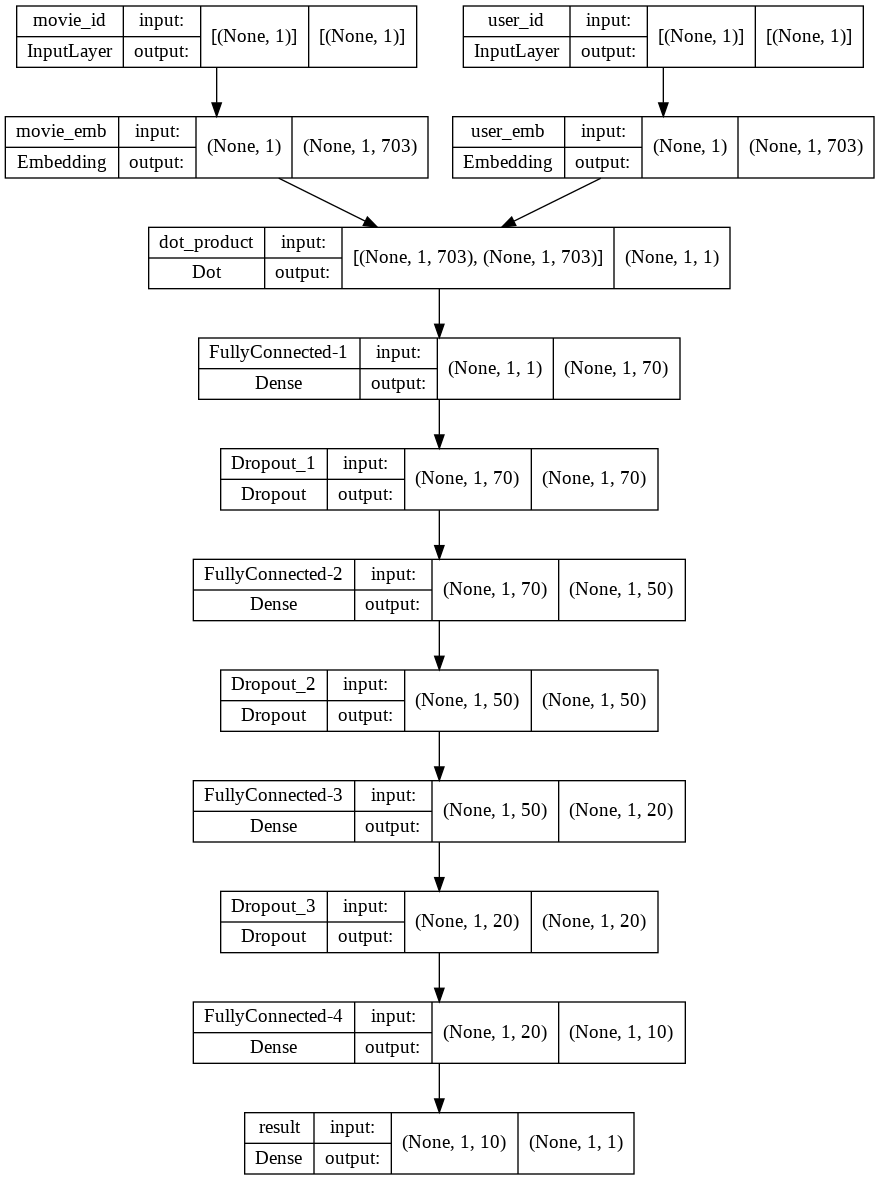

In [80]:
tf.keras.utils.plot_model(model, show_shapes=True)

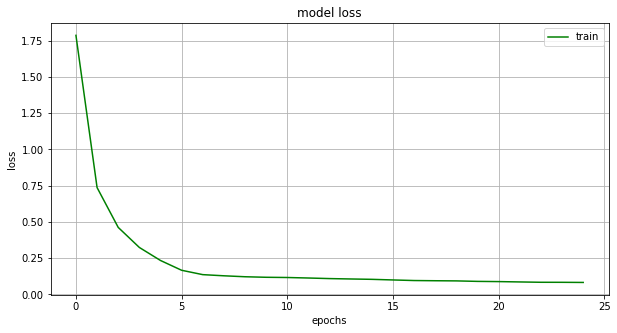

In [81]:
rcParams['figure.figsize'] = 10, 5
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

# **Recommend Movies**

In [174]:
# getting all the train movieid-embedding mapping
for _id in trainfinaldata.newmovieid.unique():
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(int(_id), val)

In [173]:
TEST_USER_ID = 1
#get the embedding of this user
user_embedding = user_model.predict([TEST_USER_ID]).reshape(1,-1)[0]
MOVIE_EMBEDDING_LIST=[]

In [175]:
#create the KNN model
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDING_LIST, trainfinaldata.newmovieid.unique())

KNeighborsClassifier(n_neighbors=11)

In [176]:
def recommend_movies_by_Embb(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['newmovieid'])
    return df_indices.merge(finaldata,on='newmovieid',how='inner',suffixes=['_u', '_m'])['movietitle']

In [177]:
# get the recommendation
recommend_movies_by_Embb(user_embedding).unique().tolist()

['Harold and Maude',
 'Back to the Future',
 'Strange Days',
 'Wrong Trousers',
 'Stargate',
 'Truth About Cats & Dogs',
 'Some Like It Hot',
 'On Golden Pond',
 'Crucible',
 'I Know What You Did Last Summer']

# **User Profile modeling**

In [ ]:
def getUsersAvgRating(df):
  return df['rating'].mean()

item to movie map list

In [ ]:
itemprofilemodelingitems=data.groupby('itemid')

In [ ]:
itemprofilemodelingitems=pd.DataFrame(itemprofilemodelingitems,columns=['itemid','group'])

In [ ]:
itemmoviesids={}
for i, row in itemprofilemodelingitems.iterrows():
  df=row['group']
  itemmoviesids[row['itemid']]=df['userid'].tolist()

In [ ]:
itemmoviesids=pd.DataFrame(itemmoviesids.items(),columns=['itemid','userlist'])
itemmoviesids

,itemid,userlist
0,1,"[308, 280, 5, 109, 181, 95, 268, 189, 145, 158..."
1,2,"[5, 268, 276, 217, 87, 250, 201, 64, 13, 95, 2..."
2,3,"[181, 160, 130, 49, 320, 145, 95, 99, 267, 417..."
3,4,"[99, 194, 207, 62, 295, 201, 10, 308, 328, 109..."
4,5,"[293, 43, 311, 109, 344, 145, 314, 308, 280, 4..."
...,...,...
460,1039,"[243, 286, 288, 215, 177, 292, 144, 214, 299, ..."
461,1047,"[117, 56, 299, 57, 342, 87, 92, 216, 130, 59, ..."
462,1048,"[94, 279, 89, 181, 393, 342, 345, 303, 90, 244..."
463,1074,"[125, 299, 94, 87, 151, 244, 62, 85, 336, 361,..."


movie to items map list

In [ ]:
dataprofilemodeling=data.groupby('userid')
dataavgrating=pd.DataFrame(dataprofilemodeling.apply(lambda x:getUsersAvgRating(x)),columns=['avgrating'])

In [ ]:
dataprofilemodeling=pd.DataFrame(dataprofilemodeling,columns=['userid','group'])

In [ ]:
dataprofilemodeling=dataprofilemodeling.join(dataavgrating,on=['userid'])

In [ ]:
aboveAvgMoviesid={}
for i, row in dataprofilemodeling.iterrows():
  df=row['group']
  aboveAvgMoviesid[row['userid']]=df[df['rating']>=df['rating'].mean()]['itemid'].tolist()

In [ ]:
allmovies={}
for i, row in dataprofilemodeling.iterrows():
  df=row['group']
  allmovies[row['userid']]=df['itemid'].tolist()

In [ ]:
aboveAvgMoviesid=pd.DataFrame(aboveAvgMoviesid.items(),columns=['userid','itemidsAboveAvgRating'])
aboveAvgMoviesid

,userid,itemidsAboveAvgRating
0,1,"[33, 20, 202, 265, 47, 222, 227, 90, 64, 228, ..."
1,5,"[17, 1, 211, 382, 62, 24, 423, 222, 173, 436, ..."
2,6,"[14, 98, 463, 517, 23, 478, 357, 275, 221, 211..."
3,7,"[661, 378, 200, 451, 81, 576, 528, 582, 127, 1..."
4,10,"[100, 285, 504, 655, 124, 22, 200, 223, 135, 4..."
...,...,...
444,936,"[285, 340, 281, 298, 111, 313, 250, 14, 249, 1..."
445,938,"[864, 313, 763, 333, 476, 1012, 181, 1014, 151..."
446,940,"[272, 655, 315, 66, 96, 194, 172, 8, 56, 147, ..."
447,942,"[423, 427, 347, 304, 193, 31, 131, 172, 496, 9..."


In [ ]:
allmovies=pd.DataFrame(allmovies.items(),columns=['userid','allmovies'])
allmovies

,userid,allmovies
0,1,"[33, 20, 202, 265, 155, 117, 47, 222, 227, 17,..."
1,5,"[2, 17, 225, 1, 98, 211, 382, 62, 231, 24, 423..."
2,6,"[86, 14, 98, 463, 301, 258, 69, 517, 23, 478, ..."
3,7,"[32, 479, 455, 382, 163, 430, 661, 378, 200, 5..."
4,10,"[175, 7, 100, 461, 285, 504, 289, 340, 657, 46..."
...,...,...
444,936,"[285, 340, 106, 281, 298, 111, 313, 250, 14, 2..."
445,938,"[864, 122, 313, 240, 125, 988, 477, 763, 333, ..."
446,940,"[193, 568, 14, 205, 272, 655, 315, 66, 873, 28..."
447,942,"[117, 200, 604, 423, 427, 323, 584, 347, 313, ..."


In [ ]:
trainTestSplit=allmovies['allmovies'].apply(lambda x:train_test_split(x, test_size=0.2, random_state=69))

In [ ]:
train=[]
test=[]
for i in list(trainTestSplit):
  train.append(i[0])
  test.append(i[1])

In [ ]:
allmovies['train']=train
allmovies['test']=test
allmovies

,userid,allmovies,train,test
0,1,"[33, 20, 202, 265, 155, 117, 47, 222, 227, 17,...","[204, 90, 71, 69, 7, 238, 143, 94, 141, 31, 13...","[218, 219, 198, 184, 67, 157, 205, 125, 154, 1..."
1,5,"[2, 17, 225, 1, 98, 211, 382, 62, 231, 24, 423...","[380, 420, 417, 99, 200, 433, 234, 227, 211, 4...","[231, 183, 173, 423, 405, 69, 436, 429, 421, 1..."
2,6,"[86, 14, 98, 463, 301, 258, 69, 517, 23, 478, ...","[482, 136, 9, 405, 483, 285, 187, 188, 248, 47...","[462, 321, 527, 520, 514, 461, 133, 23, 268, 4..."
3,7,"[32, 479, 455, 382, 163, 430, 661, 378, 200, 5...","[71, 367, 501, 192, 51, 474, 307, 682, 604, 26...","[12, 679, 324, 463, 465, 39, 655, 530, 177, 16..."
4,10,"[175, 7, 100, 461, 285, 504, 289, 340, 657, 46...","[629, 1, 203, 483, 156, 558, 124, 9, 70, 498, ...","[197, 479, 238, 482, 294, 199, 191, 285, 116, ..."
...,...,...,...,...
444,936,"[285, 340, 106, 281, 298, 111, 313, 250, 14, 2...","[258, 313, 259, 301, 988, 340, 255, 319, 118, ...","[717, 282, 815, 928, 455, 100, 181, 243, 14, 2..."
445,938,"[864, 122, 313, 240, 125, 988, 477, 763, 333, ...","[358, 250, 276, 281, 259, 122, 257, 118, 111, ...","[471, 546, 225, 273, 121, 742, 9, 300, 333, 47..."
446,940,"[193, 568, 14, 205, 272, 655, 315, 66, 873, 28...","[358, 89, 655, 151, 629, 347, 315, 164, 153, 6...","[191, 343, 181, 82, 300, 873, 751, 264, 302, 2..."
447,942,"[117, 200, 604, 423, 427, 323, 584, 347, 313, ...","[315, 328, 200, 272, 435, 514, 511, 484, 31, 2...","[427, 234, 216, 347, 480, 310, 357, 258, 478, ..."


In [ ]:
aboveavg=allmovies['allmovies'].apply(lambda x:[i for i in x if i>=(sum(x)/len(x))])

In [ ]:
allmovies['aboveavg']=aboveavg
allmovies

,userid,allmovies,train,test,aboveavg
0,1,"[33, 20, 202, 265, 155, 117, 47, 222, 227, 17,...","[204, 90, 71, 69, 7, 238, 143, 94, 141, 31, 13...","[218, 219, 198, 184, 67, 157, 205, 125, 154, 1...","[202, 265, 155, 222, 227, 228, 186, 221, 177, ..."
1,5,"[2, 17, 225, 1, 98, 211, 382, 62, 231, 24, 423...","[380, 420, 417, 99, 200, 433, 234, 227, 211, 4...","[231, 183, 173, 423, 405, 69, 436, 429, 421, 1...","[382, 423, 403, 436, 411, 402, 417, 418, 429, ..."
2,6,"[86, 14, 98, 463, 301, 258, 69, 517, 23, 478, ...","[482, 136, 9, 405, 483, 285, 187, 188, 248, 47...","[462, 321, 527, 520, 514, 461, 133, 23, 268, 4...","[463, 301, 517, 478, 508, 357, 294, 477, 475, ..."
3,7,"[32, 479, 455, 382, 163, 430, 661, 378, 200, 5...","[71, 367, 501, 192, 51, 474, 307, 682, 604, 26...","[12, 679, 324, 463, 465, 39, 655, 530, 177, 16...","[479, 455, 382, 430, 661, 378, 554, 472, 662, ..."
4,10,"[175, 7, 100, 461, 285, 504, 289, 340, 657, 46...","[629, 1, 203, 483, 156, 558, 124, 9, 70, 498, ...","[197, 479, 238, 482, 294, 199, 191, 285, 116, ...","[461, 504, 340, 657, 463, 655, 321, 651, 705, ..."
...,...,...,...,...,...
444,936,"[285, 340, 106, 281, 298, 111, 313, 250, 14, 2...","[258, 313, 259, 301, 988, 340, 255, 319, 118, ...","[717, 282, 815, 928, 455, 100, 181, 243, 14, 2...","[591, 1014, 475, 508, 628, 748, 926, 405, 476,..."
445,938,"[864, 122, 313, 240, 125, 988, 477, 763, 333, ...","[358, 250, 276, 281, 259, 122, 257, 118, 111, ...","[471, 546, 225, 273, 121, 742, 9, 300, 333, 47...","[864, 988, 477, 763, 476, 1012, 873, 1014, 717..."
446,940,"[193, 568, 14, 205, 272, 655, 315, 66, 873, 28...","[358, 89, 655, 151, 629, 347, 315, 164, 153, 6...","[191, 343, 181, 82, 300, 873, 751, 264, 302, 2...","[568, 655, 315, 873, 319, 549, 474, 317, 751, ..."
447,942,"[117, 200, 604, 423, 427, 323, 584, 347, 313, ...","[315, 328, 200, 272, 435, 514, 511, 484, 31, 2...","[427, 234, 216, 347, 480, 310, 357, 258, 478, ...","[604, 423, 427, 584, 511, 969, 479, 514, 496, ..."


In [ ]:
def getUserEmbeddingsOfUserlistDrop(userlist,it):
  drops=[]
  for i,row in it.iterrows():
    if row['movieid'] not in userlist:
      drops.append(i)
  return drops

In [ ]:
aboveavgDrop=allmovies['aboveavg'].apply(lambda x: getUserEmbeddingsOfUserlistDrop(x,items))
testDrop=allmovies['test'].apply(lambda x: getUserEmbeddingsOfUserlistDrop(x,items))
allmovies['aboveavgDrop']=aboveavgDrop
allmovies['testDrop']=testDrop

In [ ]:
embbListDrop=aboveAvgMoviesid['itemidsAboveAvgRating'].apply(lambda x:getUserEmbeddingsOfUserlistDrop(x,items))

In [ ]:
embbListDrop

0      [1, 3, 4, 6, 8, 9, 14, 16, 19, 20, 22, 23, 26,...
1      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15...
2      [1, 2, 3, 4, 5, 8, 9, 11, 13, 14, 15, 16, 17, ...
3      [0, 1, 2, 4, 8, 9, 11, 12, 13, 14, 15, 16, 18,...
4      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,...
                             ...                        
444    [1, 3, 4, 6, 8, 9, 10, 13, 14, 16, 17, 18, 20,...
445    [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...
446    [0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 1...
447    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
448    [0, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 1...
Name: itemidsAboveAvgRating, Length: 449, dtype: object

In [ ]:
embbListdf=pd.DataFrame(embbListDrop)
embbListdf = embbListdf.rename(columns={'itemidsAboveAvgRating':'drop'})
embbListdf

,drop
0,"[1, 3, 4, 6, 8, 9, 14, 16, 19, 20, 22, 23, 26,..."
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
2,"[1, 2, 3, 4, 5, 8, 9, 11, 13, 14, 15, 16, 17, ..."
3,"[0, 1, 2, 4, 8, 9, 11, 12, 13, 14, 15, 16, 18,..."
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,..."
...,...
444,"[1, 3, 4, 6, 8, 9, 10, 13, 14, 16, 17, 18, 20,..."
445,"[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
446,"[0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 1..."
447,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
aboveAvgMoviesid=aboveAvgMoviesid.join(embbListdf)
aboveAvgMoviesid

,userid,itemidsAboveAvgRating,drop
0,1,"[33, 20, 202, 265, 47, 222, 227, 90, 64, 228, ...","[1, 3, 4, 6, 8, 9, 14, 16, 19, 20, 22, 23, 26,..."
1,5,"[17, 1, 211, 382, 62, 24, 423, 222, 173, 436, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15..."
2,6,"[14, 98, 463, 517, 23, 478, 357, 275, 221, 211...","[1, 2, 3, 4, 5, 8, 9, 11, 13, 14, 15, 16, 17, ..."
3,7,"[661, 378, 200, 451, 81, 576, 528, 582, 127, 1...","[0, 1, 2, 4, 8, 9, 11, 12, 13, 14, 15, 16, 18,..."
4,10,"[100, 285, 504, 655, 124, 22, 200, 223, 135, 4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,..."
...,...,...,...
444,936,"[285, 340, 281, 298, 111, 313, 250, 14, 249, 1...","[1, 3, 4, 6, 8, 9, 10, 13, 14, 16, 17, 18, 20,..."
445,938,"[864, 313, 763, 333, 476, 1012, 181, 1014, 151...","[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
446,940,"[272, 655, 315, 66, 96, 194, 172, 8, 56, 147, ...","[0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 1..."
447,942,"[423, 427, 347, 304, 193, 31, 131, 172, 496, 9...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
index=0
maxmov=0
for i,row in allmovies.iterrows():
  if maxmov<len(row['aboveavg']):
    maxmov=len(row['aboveavg'])
    index=i

In [ ]:
index,maxmov

(6, 147)

K-Means clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
twodEmbeddings=TSNE(n_components=2, learning_rate='auto',init='pca0',perplexity=40,n_iter=2500,random_state=69).fit_transform(np.array(items['finalvec'].tolist()))

138
62


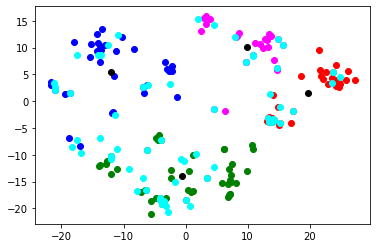

In [ ]:
twodEmbeddingsdf = pd.DataFrame(data=twodEmbeddings)
twodEmbeddingsdf.drop(allmovies['aboveavgDrop'][6], inplace = True)
twodEmbeddingsdf = twodEmbeddingsdf.reset_index()
twodEmbeddingsdf.drop('index', axis=1, inplace=True)
X_embedd = np.array(twodEmbeddingsdf)
print(len(X_embedd))
kmeans = KMeans(n_clusters=4 if len(X_embedd)>=4 else len(X_embedd), random_state=0).fit(X_embedd)

twodEmbeddingsTestdf = pd.DataFrame(data=twodEmbeddings)
twodEmbeddingsTestdf.drop(allmovies['testDrop'][6], inplace = True)
twodEmbeddingsTestdf = twodEmbeddingsTestdf.reset_index()
twodEmbeddingsTestdf.drop('index', axis=1, inplace=True)
X_embedd_test = np.array(twodEmbeddingsTestdf)
print(len(X_embedd_test))

import matplotlib.pyplot as plt
 
plotembb0=[]
plotembb1=[]
plotembb2=[]
plotembb3=[]

for i,v in enumerate(list(kmeans.labels_)):
  if v == 1:
    plotembb1.append(X_embedd[i])
  elif v == 2:
    plotembb2.append(X_embedd[i])
  elif v == 3:
    plotembb3.append(X_embedd[i])
  else:
    plotembb0.append(X_embedd[i])

plotembb0=np.array(plotembb0)
plotembb1=np.array(plotembb1)
plotembb2=np.array(plotembb2)
plotembb3=np.array(plotembb3)

plt.scatter(plotembb0[:,0] , plotembb0[:,1], color = 'red')
plt.scatter(plotembb1[:,0] , plotembb1[:,1], color = 'blue')
plt.scatter(plotembb2[:,0] , plotembb2[:,1], color = 'green')
plt.scatter(plotembb3[:,0] , plotembb3[:,1], color = 'magenta')
for i in kmeans.cluster_centers_:
  plt.scatter([i[0]] , [i[1]], color='black')

for i in X_embedd_test:
  plt.scatter([i[0]],[i[1]],color='cyan')
plt.show()

In [ ]:
def recomendMovie(movievec,userclusters,theta):
  for i in userclusters:
    c=cosine_similarity([movievec],[i])[0][0]
    if  c>=theta:
      # print(c)
      return True
  return False

Positive correct classification

In [ ]:
# yy

Negative correct classification

In [ ]:
# nn

Pred True actual False

In [ ]:
# ny

Pred False actual True

In [ ]:
# yn

In [ ]:
def getCM(pred,gold):
  yy=0
  nn=0
  yn=0
  ny=0
  for k in pred:
    if pred[k]==gold[k]==True:
      yy=yy+1
    if pred[k]==gold[k]==False:
      nn=nn+1
    if gold[k]==True and pred[k]==False:
      yn=yn+1
    if gold[k]==False and pred[k]==True:
      ny=ny+1
  return [[nn,ny],[yn,yy]]

In [ ]:
def getPreRecAcc(cm):
  pre = round(cm[1][1]/(cm[1][1]+cm[0][1]) if cm[1][1]+cm[0][1]!=0 else 0, 2)
  rec = round(cm[1][1]/(cm[1][1]+cm[1][0]) if (cm[1][1]+cm[1][0])!=0 else 0, 2)
  acc = round((cm[1][1]+cm[0][0])/(cm[0][0]+cm[1][0]+cm[1][1]+cm[0][1]) if (cm[0][0]+cm[1][0]+cm[1][1]+cm[0][1])!=0 else 0, 2)
  f1 = round(2*(pre*rec)/(pre+rec) if (pre+rec)!=0 else 0, 2)
  return pre,rec,f1,acc

In [ ]:
def userProfileRecTest(k, theta, movEmbeddings, aboveAvgMoviesid, userindex):
  twodEmbeddingsdf = pd.DataFrame(data=movEmbeddings)
  twodEmbeddingsdf.drop(aboveAvgMoviesid['aboveavgDrop'][userindex], inplace = True)
  twodEmbeddingsdf = twodEmbeddingsdf.reset_index()
  twodEmbeddingsdf.drop('index', axis=1, inplace=True)
  X_embedd = np.array(twodEmbeddingsdf)
  kmeans = KMeans(n_clusters=k if len(X_embedd)>=k else len(X_embedd), random_state=0).fit(X_embedd)
  rec={}
  truth={}
  twodEmbeddingsTestdf = pd.DataFrame(data=twodEmbeddings)
  twodEmbeddingsTestdf.drop(aboveAvgMoviesid['testDrop'][userindex], inplace = True)
  twodEmbeddingsTestdf = twodEmbeddingsTestdf.reset_index()
  twodEmbeddingsTestdf.drop('index', axis=1, inplace=True)
  X_embedd_test = np.array(twodEmbeddingsTestdf)
  for i, row in items.iterrows():
    if row['movieid'] in aboveAvgMoviesid['test']:
      rec[row['movieid']] = recomendMovie(movEmbeddings[i],kmeans.cluster_centers_.tolist(),theta)
      if row['movieid'] in allmovies['test'][userindex]:
        truth[row['movieid']] = True
      else:
        truth[row['movieid']] = False
  print(len(X_embedd),len(X_embedd_test))
  print(len(rec),rec)
  print(len(truth),truth)
  cm=getCM(rec,truth)
  return getPreRecAcc(cm)

In [ ]:
def userProfileRec(k, theta, movEmbeddings, aboveAvgMoviesid, userindex):
  twodEmbeddingsdf = pd.DataFrame(data=movEmbeddings)
  twodEmbeddingsdf.drop(aboveAvgMoviesid['drop'][userindex], inplace = True)
  twodEmbeddingsdf = twodEmbeddingsdf.reset_index()
  twodEmbeddingsdf.drop('index', axis=1, inplace=True)
  X_embedd = np.array(twodEmbeddingsdf)
  kmeans = KMeans(n_clusters=k if len(X_embedd)>=k else len(X_embedd), random_state=0).fit(X_embedd)
  rec={}
  truth={}
  for i, row in testItems.iterrows():
    rec[row['movieid']] = recomendMovie(movEmbeddings[i],kmeans.cluster_centers_.tolist(),theta)
    if row['movieid'] in allmovies['allmovies'][userindex]:
      truth[row['movieid']] = True
    else:
      truth[row['movieid']] = False
  cm=getCM(rec,truth)
  return getPreRecAcc(cm)

In [ ]:
def getKmeansCentres(k, theta, movEmbeddings, aboveAvgMoviesid, userindex):
  twodEmbeddingsdf = pd.DataFrame(data=twodEmbeddings)
  twodEmbeddingsdf.drop(aboveAvgMoviesid['drop'][userindex], inplace = True)
  twodEmbeddingsdf = twodEmbeddingsdf.reset_index()
  twodEmbeddingsdf.drop('index', axis=1, inplace=True)
  X_embedd = np.array(twodEmbeddingsdf)
  kmeans = KMeans(n_clusters=k if len(X_embedd)>=k else len(X_embedd), random_state=0).fit(X_embedd)
  return kmeans.cluster_centers_.tolist()

In [ ]:
uprof=[]
for i, row in allmovies.iterrows():
  print(i)
  uprof.append(userProfileRecTest(3,0.9,twodEmbeddings,allmovies,i))

In [ ]:
# uprof=[]
# for i, row in aboveAvgMoviesid.iterrows():
#   print(i)
#   uprof.append(userProfileRec(4,0.7,twodEmbeddings,aboveAvgMoviesid,i))

In [ ]:
# centres=[]
# for i, row in aboveAvgMoviesid.iterrows():
#   print(i)
#   centres.append(getKmeansCentres(3,0.7,twodEmbeddings,aboveAvgMoviesid,i))

In [ ]:
# centres=[]
# for i, row in aboveAvgMoviesid.iterrows():
#   print(i)
#   centres.append(getKmeansCentres(3,0.7,twodEmbeddings,aboveAvgMoviesid,i))

In [ ]:
bkuprof=uprof

In [ ]:
bkuprof=np.array(bkuprof)

In [ ]:
np.shape(bkuprof)

In [ ]:
bkuprof.max(axis=0)

In [ ]:
bkuprof.mean(axis=0)

In [ ]:
bkuprof.min(axis=0)

# **Plotting MAP@K comparisons**

In [ ]:
results=[]
for i in range(2,8):
  resultsRow=[]
  for j in range(50,101,10):
    if j==100:
      j=j-1
    print(i,j)
    uprof=[]
    for k, row in aboveAvgMoviesid.iterrows():
      uprof.append(userProfileRec(i,round(j/100,2),twodEmbeddings,aboveAvgMoviesid,k))
    uprof=np.array(uprof)
    resultsRow.append([uprof.max(axis=0),uprof.mean(axis=0),uprof.min(axis=0)])
  results.append(resultsRow)

Accuracies

In [ ]:
fig = go.Figure()
for i in range(8-2):
  max=[]
  mean=[]
  min=[]
  for j in range(11-5):
    max.append(results[i][j][0][3])
    mean.append(results[i][j][1][3])
    min.append(results[i][j][2][3])
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=max, name=f'Max K:{i+2}'))
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=mean, name=f'Mean K:{i+2}'))
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=min, name=f'Min K:{i+2}'))
fig.update_layout(title='Max,Mean and Min Accuracies',
                   xaxis_title='theta',
                   yaxis_title='Accuracy')
fig.show()

F1

In [ ]:
fig = go.Figure()
for i in range(8-2):
  max=[]
  mean=[]
  min=[]
  for j in range(11-5):
    max.append(results[i][j][0][2])
    mean.append(results[i][j][1][2])
    min.append(results[i][j][2][2])
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=max, name=f'Max K:{i+2}'))
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=mean, name=f'Mean K:{i+2}'))
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=min, name=f'Min K:{i+2}'))
fig.update_layout(title='Max,Mean and Min F1',
                   xaxis_title='theta',
                   yaxis_title='F1')
fig.show()

Recall

In [ ]:
fig = go.Figure()
for i in range(8-2):
  max=[]
  mean=[]
  min=[]
  for j in range(11-5):
    max.append(results[i][j][0][1])
    mean.append(results[i][j][1][1])
    min.append(results[i][j][2][1])
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=max, name=f'Max K:{i+2}'))
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=mean, name=f'Mean K:{i+2}'))
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=min, name=f'Min K:{i+2}'))
fig.update_layout(title='Max,Mean and Min Recall',
                   xaxis_title='theta',
                   yaxis_title='Recall')
fig.show()

Precision

In [ ]:
fig = go.Figure()
for i in range(8-2):
  max=[]
  mean=[]
  min=[]
  for j in range(11-5):
    max.append(results[i][j][0][0])
    mean.append(results[i][j][1][0])
    min.append(results[i][j][2][0])
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=max, name=f'Max K:{i+2}'))
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=mean, name=f'Mean K:{i+2}'))
  fig.add_trace(go.Scatter(x=[t/10 if t!=10 else 99/100 for t in list(range(5,11))], y=min, name=f'Min K:{i+2}'))
fig.update_layout(title='Max,Mean and Min Precision',
                   xaxis_title='theta',
                   yaxis_title='Precision')
fig.show()